In [6]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import SnowballStemmer


import re
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

import emoji
import regex as re



In [7]:
data = pd.read_csv('train_spam.csv')

In [8]:
data

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...
...,...,...
16273,spam,if you are interested in binary options tradin...
16274,spam,dirty pictureblyk on aircel thanks you for bei...
16275,ham,or you could do this g on mon 1635465 sep 1635...
16276,ham,insta reels par 80 गंद bhara pada hai 👀 kuch b...


## Data Preprocessing

In [9]:
data.dropna(inplace=True)
data.drop_duplicates(keep='first', inplace=True)

In [10]:
data.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


## EDA

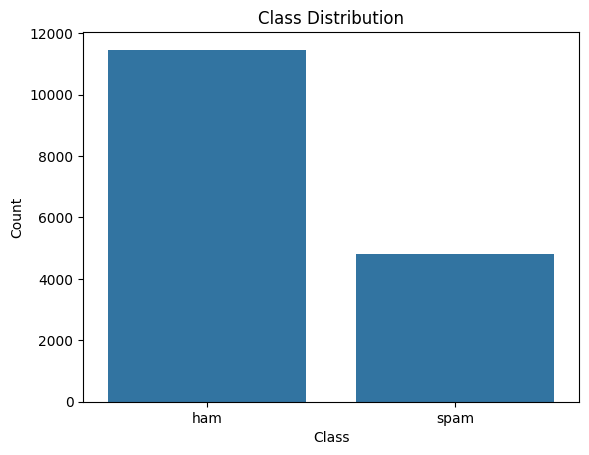

In [11]:
sns.countplot(data=data, x='text_type')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

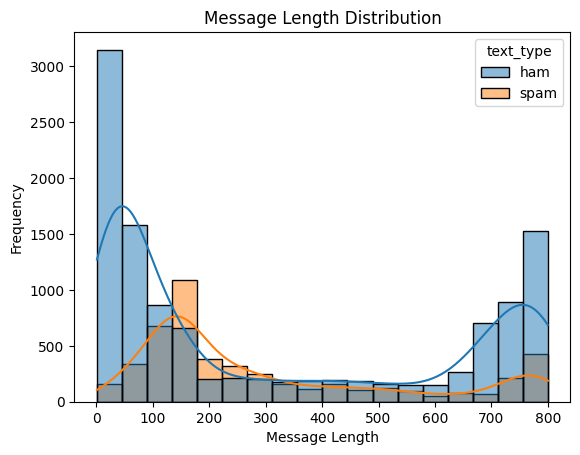

In [12]:
data['text_length'] = data['text'].apply(len)
sns.histplot(data=data, x='text_length', hue='text_type', kde=True)
plt.title('Message Length Distribution')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.show()

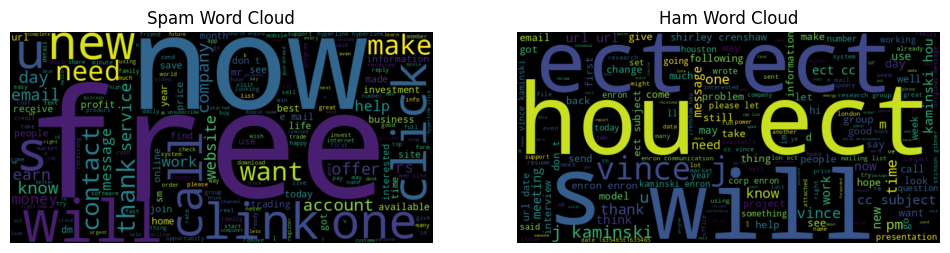

In [13]:
spam_text = ' '.join(data[data['text_type'] == 'spam']['text'])
ham_text = ' '.join(data[data['text_type'] == 'ham']['text'])

spam_wordcloud = WordCloud(width=800, height=400).generate(spam_text)
ham_wordcloud = WordCloud(width=800, height=400).generate(ham_text)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(spam_wordcloud, interpolation='bilinear')
plt.title('Spam Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ham_wordcloud, interpolation='bilinear')
plt.title('Ham Word Cloud')
plt.axis('off')

plt.show()

In [14]:
def count_emojis(text):
    emoji_list = [c for c in text if c in emoji.EMOJI_DATA]
    return len(emoji_list)

data['num_emojis'] = data['text'].apply(count_emojis)

print("Total emojis in spam messages:", data[data['text_type'] == 'spam']['num_emojis'].sum()/data[data['text_type'] == 'spam']['num_emojis'].count())
print("Total emojis in ham messages:",  data[data['text_type'] == 'ham']['num_emojis'].sum()/data[data['text_type'] == 'spam']['num_emojis'].count())

Total emojis in spam messages: 2.407153254314826
Total emojis in ham messages: 0.050322312331045956


Из EDA мы можем заметить, что:
1. Гораздо больше hams, чем spams
2. Длина сообщения не может помочь нам идентифицировать спам
3. В спаме мы часто видим слова "free, will, now, make, click, need", а в hamе "will, know, ect"
4. В спаме больше emojis: на одно сообщение 2, когда в обычных сообщениях около 0.

## Text Processing

In [15]:
encoder = LabelEncoder()
data['text_type'] = encoder.fit_transform(data['text_type'])

In [16]:
def stemmatize_text(text):
  stemmer = SnowballStemmer("english")

  words = text.split()
  words = [stemmer.stem(word) for word in words]

  return ' '.join(words)

In [17]:
data['text'] = data['text'].apply(stemmatize_text)

## Data Preparation

In [61]:
X = data.text
y = data.text_type

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
tfidf = TfidfVectorizer()

In [69]:
X_train = tfidf.fit_transform(X_train).toarray()
X_test = tfidf.transform(X_test).toarray()

## Models

In [23]:
mnb = MultinomialNB()
rfc = RandomForestClassifier(n_estimators=50, random_state=42)
bnb = BernoulliNB()
svc = SVC(probability=True)
mnb = MultinomialNB()
lrc = LogisticRegression(solver='liblinear', penalty='l1')
etc = ExtraTreesClassifier(n_estimators=50, random_state=42)
xgb = XGBClassifier(n_estimators=50,random_state=2)

In [81]:
models = {
    'MultinomialNB': mnb,
    'BernoulliNB': bnb,
    'LR': lrc,
    'RF': rfc,
    'XGB': xgb,
}

In [82]:
for name, model in models.items():
    model.fit(X_train, y_train)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print(f'{name} roc-auc: {roc_auc}')

MultinomialNB roc-auc: 0.9332559276077286
BernoulliNB roc-auc: 0.9704836917155716
LR roc-auc: 0.9654538873755651
RF roc-auc: 0.9836977628938992
XGB roc-auc: 0.9636847096366993


In [24]:
etc.fit(X_train, y_train)
roc_auc = roc_auc_score(y_test, etc.predict_proba(X_test)[:, 1])
print(f'ETC roc-auc: {roc_auc}')

ETC roc-auc: 0.9847842651361118


Лучшей моделью оказалась ExtraTreesClassifier

## Test Inference

In [65]:
test = pd.read_csv('test_spam.csv')

In [66]:
test['text'] = test['text'].apply(stemmatize_text)

In [71]:
testing = tfidf.transform(test.text).toarray()

In [77]:
test['score'] = etc.predict_proba(testing)[:, 1]

In [80]:
test.to_csv('vk_test_inference.csv')